In [10]:
!pip install --upgrade pip
!pip install --upgrade datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio
PYTORCH_ENABLE_MPS_FALLBACK=1
PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

zsh:1: no matches found: datasets[audio]


In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
from datasets import load_dataset, DatasetDict

minds_de_ds = load_dataset('csv', data_files='./MInDS-14/text/de-DE.csv')

train_testvalid = minds_de_ds['train'].train_test_split(test_size=0.2)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

print(ds)

DatasetDict({
    train: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent'],
        num_rows: 488
    })
    test: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent'],
        num_rows: 62
    })
    valid: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent'],
        num_rows: 61
    })
})


In [13]:
import os
import librosa

def load_audio_data(batch, audio_base_path):
    audio_files = [os.path.join(audio_base_path, filepath) for filepath in batch['filepath']]
    audio_data = [librosa.load(file_path, sr=None) for file_path in audio_files]
    
    # Separate audio data and sample rates
    audio_signals = [data[0] for data in audio_data]
    sample_rates = [data[1] for data in audio_data]
    
    batch['audio'] = [{'path': file_path, 'array': audio, 'sampling_rate': sr} for file_path, audio, sr in zip(audio_files, audio_signals, sample_rates)]
    return batch

In [14]:
# Apply the function to load audio data and add it to the dataset
audio_base_path = "./MInDS-14/audio"
ds = ds.map(load_audio_data, fn_kwargs={'audio_base_path': audio_base_path}, batched=True)
print(ds)

Map: 100%|██████████| 61/61 [00:00<00:00, 1401.08 examples/s]

DatasetDict({
    train: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent', 'audio'],
        num_rows: 488
    })
    test: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent', 'audio'],
        num_rows: 62
    })
    valid: Dataset({
        features: ['filepath', 'text_asr', 'text_translated', 'intent', 'audio'],
        num_rows: 61
    })
})


In [15]:
# Remove the specified columns
ds = ds.remove_columns(["filepath","text_translated", "intent"])

In [16]:
from datasets import Audio

ds = ds.cast_column("audio", Audio(sampling_rate=16_000))
ds2 = ds

In [17]:
# mps config
import torch

device = "mps" if torch.backends.mps.is_available() else "cpu"
torch_dtype = torch.float16 if torch.backends.mps.is_available() else torch.float32

In [18]:
from transformers import WhisperFeatureExtractor, WhisperTokenizer, WhisperProcessor
MODEL_NAME = "openai/whisper-large-v3"
feature_extractor = WhisperFeatureExtractor.from_pretrained(MODEL_NAME)
tokenizer = WhisperTokenizer.from_pretrained(MODEL_NAME, language="german", task="transcribe")
processor = WhisperProcessor.from_pretrained(MODEL_NAME, language="german", task="transcribe")

In [19]:
print(ds["train"][0])

{'text_asr': 'grüß Gott könnten Sie mir bitte sagen welche Zahlungen in letzter Zeit von meinem Konto getätigt wurden ich sehe hier nämlich eine Transaktion die ich nicht selbst getätigt habe', 'audio': {'path': None, 'array': array([ 4.68769576e-06,  2.67913128e-06, -4.74229273e-06, ...,
        2.93334277e-04,  2.75355560e-04,  1.11240457e-04]), 'sampling_rate': 16000}}


In [20]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["text_asr"]).input_ids
    return batch

In [21]:
ds = ds.map(prepare_dataset, remove_columns=ds.column_names["train"], num_proc=4)

Map (num_proc=4): 100%|██████████| 61/61 [00:01<00:00, 51.99 examples/s]


In [22]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

In [23]:
model.generation_config.language = "german"
model.generation_config.task = "transcribe"
model.generation_config.forced_decoder_ids = None

In [24]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [25]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

In [26]:
import evaluate

metric = evaluate.load("wer")

In [27]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [28]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-large-ger-lr1.5",  
    gradient_accumulation_steps=2,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=4,
    max_steps=61,
    gradient_checkpointing=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    save_steps=8,
    eval_steps=8,
    logging_steps=8,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
)

In [29]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

max_steps is given, it will override any value given in num_train_epochs


In [30]:
processor.save_pretrained(training_args.output_dir)

[]

In [31]:
trainer.train()

  0%|          | 0/61 [00:00<?, ?it/s]Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


RuntimeError: MPS backend out of memory (MPS allocated: 16.64 GB, other allocations: 406.12 MB, max allowed: 18.13 GB). Tried to allocate 1.34 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
import pandas as pd
trainer_history = pd.DataFrame(trainer.state.log_history)
trainer_history.groupby('step').first().reset_index()
trainer_history

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_wer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.9449,9.307695,9.298246e-06,0.131148,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.131148,8,0.693949,21.669477,59.3241,1.045,0.135,NaN,NaN,NaN,NaN,NaN
2,0.5749,7.661010,7.894737e-06,0.262295,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.262295,16,0.480464,18.549747,67.3638,0.920,0.119,NaN,NaN,NaN,NaN,NaN
4,0.5448,12.722649,6.491228e-06,0.393443,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.393443,24,0.468571,20.320405,70.6336,0.878,0.113,NaN,NaN,NaN,NaN,NaN
6,0.5174,9.939457,5.087719e-06,0.524590,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,0.524590,32,0.444150,18.212479,69.6845,0.890,0.115,NaN,NaN,NaN,NaN,NaN
8,0.3649,8.216652,3.684211e-06,0.655738,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,0.655738,40,0.433102,18.128162,68.6008,0.904,0.117,NaN,NaN,NaN,NaN,NaN


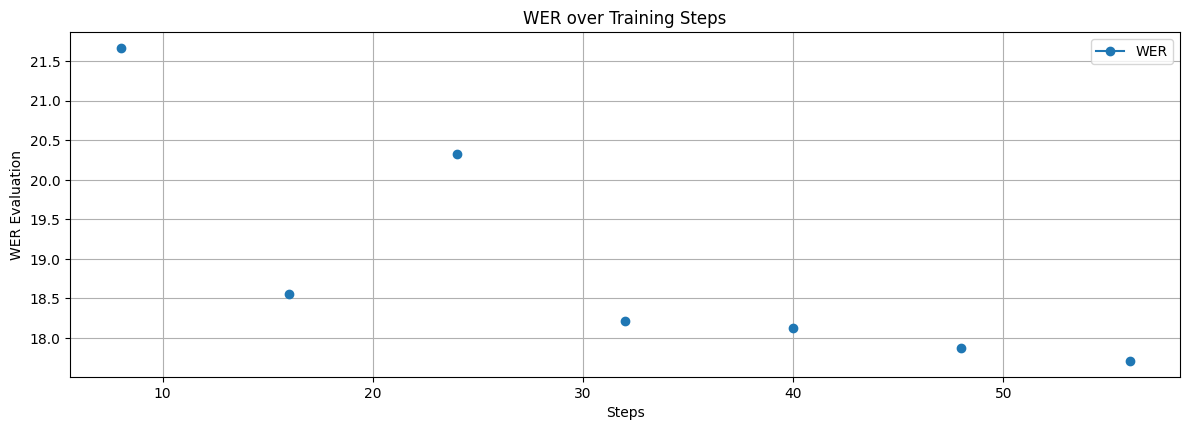

In [ ]:
import matplotlib.pyplot as plt

# Plot WER over training steps
plt.figure(figsize=(12, 8))

# Plot WER
plt.subplot(2, 1, 1)
plt.plot(trainer_history['step'], trainer_history['eval_wer'], marker='o', label='WER')
plt.title("WER over Training Steps")
plt.xlabel("Steps")
plt.ylabel("WER Evaluation")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import time
from transformers import WhisperForConditionalGeneration, WhisperProcessor

# Define the path to the model checkpoint
model_path = "/Users/shabiras/Developer/Learn/AI/NLP/INDONESIA AI/Project_3/whisper-small-ger-lr3.5/checkpoint-61"

# Load the best fine-tuned model
try:
    model = WhisperForConditionalGeneration.from_pretrained(model_path)
    processor = WhisperProcessor.from_pretrained(model_path)
    print("Model and processor loaded successfully.")
except OSError as e:
    print(f"Error loading model or processor: {e}")

# Inference function
def transcribe(audio):
    input_features = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt").input_features
    predicted_ids = model.generate(input_features)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
    return transcription[0]

Error loading model or processor: Can't load tokenizer for '/Users/shabiras/Developer/Learn/AI/NLP/INDONESIA AI/Project_3/whisper-small-ger-lr3.5/checkpoint-61'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure '/Users/shabiras/Developer/Learn/AI/NLP/INDONESIA AI/Project_3/whisper-small-ger-lr3.5/checkpoint-61' is the correct path to a directory containing all relevant files for a WhisperTokenizer tokenizer.


In [ ]:
# Run inference on three samples
for i in range(3):
    sample = ds2["test"][i]
    
    start_time = time.time()
    transcription = transcribe(sample["audio"])
    end_time = time.time()
    
    inference_time = end_time - start_time
    
    print(f"Sample {i+1}:")
    print(f"Reference: {sample['text_asr']}")
    print(f"Prediction: {transcription}")
    print(f"Inference time: {inference_time:.4f} seconds")
    print()

# Calculate overall WER for these three samples
wer = metric.compute(predictions=[transcribe(ds["test"][i]["audio"]) for i in range(3)],
                     references=[ds2["test"][i]["text_asr"] for i in range(3)])
print(f"WER for 3 samples: {wer}")

Sample 1:
Reference: guten Tag ich möchte einen Konto mit meinem partner eröffnen wie kann ich bitte ein Gemeinschaftskonto einrichten kann ich das in der abmachen
Prediction: guten Tag ich möchte einen Konto mit meinem Partner eröffnen wie kann ich bitte ein Gemeinschaftskonto einrichten kann ich das in der Art machen
Inference time: 1.0522 seconds

Sample 2:
Reference: hallo guten Tag ich rufe an weil meine Kreditkarte nicht mehr funktioniert ich habe vorhin versucht im Laden zu bezahlen ich habe die Karte eingesteckt ich habe versucht kontaktlos zu bezahlen und ich kann damit einfach nicht bezahlen funktioniert nicht die Karte scheint kaputt zu sein
Prediction: Hallo guten Tag ich rufe an weil meine Kreditkarte nicht mehr funktioniert ich habe vorhin versucht im Laden zu bezahlen ich habe die Karte eingesteckt ich habe es versucht Kontaktlos zu bezahlen und ich kann damit einfach nicht bezahlen es funktioniert nicht die Karte schreien kaputt zu sein
Inference time: 1.6257 seconds

S

In [ ]:
!pip install sounddevice

In [ ]:
import sounddevice as sd
import numpy as np

# Function to record audio from the microphone
def record_audio(duration, sample_rate=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
    sd.wait()  # Wait until the recording is finished
    print("Recording finished.")
    audio = np.squeeze(audio)  # Remove single-dimensional entries
    return {"array": audio, "sampling_rate": sample_rate}

# Record audio from the microphone
duration = 5  # Record for 5 seconds
audio = record_audio(duration)

# Transcribe the recorded audio
transcription = transcribe(audio)
print("Transcription:", transcription)

Recording...
Recording finished.
Transcription: verbangen Systeme von einem vorab die ganze
